## Notebook that trains a Conditional GAN for image generation.

Image score prediction is transformed into a classification task by bucketizing these scores in a number of classes

The GAN is then given this information, both for the discriminator and the generator.

Some implementation details from: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
import torchvision
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

# set up accordingly
data_dir = "drive/My Drive/CIL/data" # directory with data files
labeled_image_dir = "labeled"       # folder within data directory with labeled images (0, 1)
scored_image_dir = "scored_128"      # folder within data directory with scored images
outf = "content"                   # folder to store the outputs from this training
device = torch.device("cuda")        # cuda or cpu
collab = True                        # google collab flag

In [2]:
# google collab
# mount drive, copy over data as zip and unzip it
if collab:
  from google.colab import drive
  drive.mount('/content/drive')
  collab_dir = "content"

  zip_path = os.path.join(data_dir, 'labeled.zip')
  !cp '{zip_path}' .
  !unzip -q labeled.zip
  !rm labeled.zip

  zip_path = os.path.join(data_dir, 'scored_128.zip')
  !cp '{zip_path}' .
  !unzip -q scored_128.zip
  !rm scored_128.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
class GalaxyDataset(torch.utils.data.Dataset):
    """
    Galaxy dataset class
    Builds a dataset from the labeled and scored images. 
    Sets labeled images to a default score.
    Divides scores into buckets for classification task.
    """

    def __init__(self, csv_file, image_dir, scored_dir=None, scores_file=None, 
                 transform=None, train=True, size=(128, 128), train_split=1, default_value=2.61, n_classes=32):
        self.labels = pd.read_csv(csv_file, index_col="Id")
        self.labels = self.labels[self.labels['Actual'] == 1.0]
        self.size = size
        self.scores = None
        self.default_value = default_value
        if scores_file is not None:
          self.scores = pd.read_csv(scores_file, index_col="Id")
        self.samples = []
        if train == True:
          self.labels = self.labels[:int(self.labels.shape[0]*train_split)]
        else:
          self.labels = self.labels[int(self.labels.shape[0]*train_split):]
        self.image_dir = image_dir
        self.transform = transform
        self.scored_dir = scored_dir
        self.y = []
        self.n_classes = n_classes
        self.load_dataset()
    
    def __len__(self):
        return len(self.samples)

    def bucketize(self, x):
      x_np = np.asarray(x)
      bins = np.asarray([(i*8)/n_classes for i in range(0, n_classes + 1)])
      result = np.digitize(x_np, bins) - 1
      return result.tolist()

    def load_dataset(self):
      print("Loading Dataset...")
      for id, _ in self.labels.iterrows():
        img_name = os.path.join(self.image_dir,
                                  str(id)+'.png')
        self.samples.append(Image.open(img_name).resize(self.size))
        self.y.append(self.default_value)
      if self.scores is not None:
        for id, score in self.scores.iterrows():
          img_name = os.path.join(self.scored_dir,
                                    str(id)+'.png')
          self.samples.append(Image.open(img_name).resize(self.size))
          self.y.append(score.item())
        
      print("Dataset Loaded")

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.samples[idx]
        if self.transform:
            image = self.transform(image)

        return image, self.bucketize(self.y[idx])

NameError: ignored

Load Dataset with appropriate transforms

In [2]:
batch_size = 64
size = (64, 64)
latent_dim = 64
n_classes = 32
train_transformation = torchvision.transforms.Compose([
                            torchvision.transforms.RandomAffine(30, translate=(0.2, 0.2)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(0, 255.0),
                            torchvision.transforms.Normalize(0.5, 0.5) ## second normalization for tanh
])
val_transformation = torchvision.transforms.Compose([
                            torchvision.transforms.RandomAffine(30, translate=(0.2, 0.2)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(0, 255.0),
                            torchvision.transforms.Normalize(0.5, 0.5) ## second normalization for tanh
])


train_dataset = GalaxyDataset(os.path.join(data_dir, "labeled.csv"), labeled_image_dir, scored_dir=scored_image_dir, scores_file=os.path.join(data_dir, "scored.csv"),  transform=train_transformation, train=True, size=size, train_split=1.0, n_classes=n_classes)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, pin_memory=True)
print("{} images loaded".format(len(train_dataset)))

NameError: ignored

In [0]:
gen_base_filters = 64
disc_base_filters = 64

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
# Label is passed into an embedding layer followed by a linear layer
# Combined with noise to generate image
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.label_linear = nn.Linear(n_classes, 4*4)
        self.label_bn = nn.BatchNorm1d(4*4)
        self.latent_conv = nn.ConvTranspose2d( latent_dim, gen_base_filters * 8, 4, 1, 0, bias=False)
        self.latent_bn = nn.BatchNorm2d(gen_base_filters * 8)
        self.main = nn.Sequential(
            # state size. (gen_base_filters*8) x 4 x 4
            nn.ConvTranspose2d((gen_base_filters * 8) + 1, gen_base_filters * 4, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(gen_base_filters * 4),
            # state size. (gen_base_filters*4) x 8 x 8
            nn.ConvTranspose2d( gen_base_filters * 4, gen_base_filters * 2, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(gen_base_filters * 2),
            # state size. (gen_base_filters*2) x 16 x 16
            nn.ConvTranspose2d( gen_base_filters * 2, gen_base_filters, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(gen_base_filters),
            # state size. (gen_base_filters) x 32 x 32
            nn.ConvTranspose2d( gen_base_filters, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input, label):
        label_filter = self.label_bn(F.relu(self.label_linear(self.label_emb(label))))
        label_filter = label_filter.view(-1, 1, 4, 4)
        noise = self.latent_bn(F.relu(self.latent_conv(input)))
        x = torch.cat([noise, label_filter], 1)
        return self.main(x)

In [7]:
gen = Generator().to(device)
gen.apply(weights_init)
print(gen)

Generator(
  (label_emb): Embedding(32, 32)
  (label_linear): Linear(in_features=32, out_features=16, bias=True)
  (label_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (latent_conv): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (latent_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (main): Sequential(
    (0): ConvTranspose2d(513, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(64, eps=

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # input is (nc) x 64 x 64
        self.img_conv = nn.Conv2d(1, disc_base_filters, 4, 2, 1, bias=False)
        self.img_relu = nn.LeakyReLU(0.2, inplace=True)
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.label_linear = nn.Linear(n_classes, 32*32)
        self.label_bn = nn.BatchNorm1d(32*32)
        self.main = nn.Sequential(
            # state size. (disc_base_filters) x 32 x 32
            nn.Conv2d(disc_base_filters + 1, disc_base_filters * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(disc_base_filters * 2),
            # state size. (disc_base_filters*2) x 16 x 16
            nn.Conv2d(disc_base_filters * 2, disc_base_filters * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(disc_base_filters * 4),
            # state size. (disc_base_filters*4) x 8 x 8
            nn.Conv2d(disc_base_filters * 4, disc_base_filters * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(disc_base_filters * 8),
            # state size. (disc_base_filters*8) x 4 x 4
            nn.Conv2d(disc_base_filters * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input, label):
        label_filter = self.label_emb(label)
        label_filter = F.relu(self.label_linear(label_filter))
        label_filter = self.label_bn(label_filter)
        label_filter = label_filter.view(-1, 1, 32, 32)
        img = self.img_relu(self.img_conv(input))
        x = torch.cat([img, label_filter], 1)
        return self.main(x)

In [15]:
disc = Discriminator().to(device)
disc.apply(weights_init)
print(disc)

Discriminator(
  (img_conv): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (img_relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (label_emb): Embedding(32, 32)
  (label_linear): Linear(in_features=32, out_features=1024, bias=True)
  (label_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (main): Sequential(
    (0): Conv2d(65, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): 

Set up training parameters

In [0]:
G_losses = []
D_losses = []
iters = 0
img_list = []

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
# generate images with score 3 (higher up we dont really have examples)
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
fixed_labels = torch.ones(batch_size, dtype=torch.long, device=device)*((int) (n_classes//8 * 3))
# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0
gen_lr = 2e-4
disc_lr = 2e-4
epochs = 2000
identity = torch.eye(n_classes, dtype=torch.long)
# generator takes this many steps for every 1 of the discriminator
gen_steps = 1
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(disc.parameters(), lr=disc_lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=gen_lr, betas=(0.5, 0.999))

Function that takes one CGAN train step

In [0]:
def gan_step(batch_num, batch, labels, disc, gen):
  ############################
  # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
  ###########################
  ## Train with all-real batch
  disc.zero_grad()
  # Format batch
  real_cpu = data.to(device)
  labels = labels.to(device)
  #labels_one_hot = identity[labels].to(device)
  b_size = real_cpu.size(0)
  label = torch.full((b_size,), real_label, device=device)
  # Forward pass real batch through D
  output = disc(real_cpu, labels).view(-1)
  # Calculate loss on all-real batch
  errD_real = criterion(output, label)
  # Calculate gradients for D in backward pass
  errD_real.backward()
  D_x = output.mean().item()

  ## Train with all-fake batch
  # Generate batch of latent vectors
  # Generate only up to 3.5 - above that we have very few samples
  noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
  fake_labels = torch.randint((int) ((n_classes/8)*3.5 + 1), (b_size,)).to(device)
  #fake_labels_one_hot = identity[fake_labels]
  # Generate fake image batch with G
  fake = gen(noise, fake_labels)
  label.fill_(fake_label)
  # Classify all fake batch with D
  output = disc(fake.detach(), fake_labels.detach()).view(-1)
  # Calculate D's loss on the all-fake batch
  errD_fake = criterion(output, label)
  # Calculate the gradients for this batch
  errD_fake.backward()
  D_G_z1 = output.mean().item()
  # Add the gradients from the all-real and all-fake batches
  errD = errD_real + errD_fake
  

  ############################
  # (2) Update G network: maximize log(D(G(z)))
  # try training discriminator more than generator
  ###########################
  for _ in range (gen_steps):
    fake = gen(noise, fake_labels)
    gen.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = disc(fake, fake_labels).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()

  # Output training stats
  if i % 5 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, epochs, i, len(train_loader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
  return errD, errG

Begin training and periodically save generator output

In [19]:
# save a grid of images generated from the same initial noise
# also save those same images but changed so that the smallest value
# corresponds to 0, and the largest to 1 (normalized)
# this allows us to see some patterns that would otherwise
# just appear as black
results_dir = "results_cgan"
if not os.path.exists(os.path.join(outf, results_dir)):
  os.mkdir(os.path.join(outf, results_dir))
  os.mkdir(os.path.join(outf, results_dir, "normalized"))
  os.mkdir(os.path.join(outf, results_dir, "unnormalized"))
for epoch in range(1, epochs + 1):
    # For each batch in the dataloader
    for i, (data, labels) in enumerate(train_loader, 0):

        errD, errG = gan_step(i, data, labels, disc, gen)
        
        # Update G
        optimizerG.step()
        # Update D
        optimizerD.step()
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (epoch % 5 == 0 and i == len(train_loader)-1):
            with torch.no_grad():
                fake = gen(fixed_noise, fixed_labels).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, pad_value=255, normalize=True, range=(-1, 1)))
            vutils.save_image(fake, os.path.join(outf, results_dir, "normalized") + "/epoch" + str(epoch) + ".png", padding=2, pad_value=1, normalize=True)
            vutils.save_image(fake, os.path.join(outf, results_dir, "unnormalized") + "/epoch" + str(epoch) + ".png", padding=2, pad_value=1, normalize=True, range=(-1, 1))

[1/2000][0/166]	Loss_D: 10.6876	Loss_G: 0.7859	D(x): 1.0000	D(G(z)): 0.4785 / 0.4785
[1/2000][5/166]	Loss_D: 10.8264	Loss_G: 0.6513	D(x): 1.0000	D(G(z)): 0.5425 / 0.5425
[1/2000][10/166]	Loss_D: 10.7862	Loss_G: 0.6596	D(x): 1.0000	D(G(z)): 0.5348 / 0.5348
[1/2000][15/166]	Loss_D: 1.2823	Loss_G: 0.6308	D(x): 0.8217	D(G(z)): 0.5636 / 0.5636
[1/2000][20/166]	Loss_D: 1.2674	Loss_G: 0.9539	D(x): 0.7747	D(G(z)): 0.5002 / 0.5002
[1/2000][25/166]	Loss_D: 0.9617	Loss_G: 0.8277	D(x): 0.7898	D(G(z)): 0.4344 / 0.4344
[1/2000][30/166]	Loss_D: 1.0903	Loss_G: 0.7027	D(x): 0.8908	D(G(z)): 0.5131 / 0.5131
[1/2000][35/166]	Loss_D: 1.2109	Loss_G: 0.6141	D(x): 0.9089	D(G(z)): 0.5683 / 0.5683
[1/2000][40/166]	Loss_D: 0.7063	Loss_G: 1.1473	D(x): 0.9143	D(G(z)): 0.3036 / 0.3036
[1/2000][45/166]	Loss_D: 1.4806	Loss_G: 0.5891	D(x): 0.9508	D(G(z)): 0.6425 / 0.6425
[1/2000][50/166]	Loss_D: 0.9592	Loss_G: 0.7555	D(x): 0.8900	D(G(z)): 0.4656 / 0.4656
[1/2000][55/166]	Loss_D: 0.9521	Loss_G: 0.7986	D(x): 0.8552	D(G(

KeyboardInterrupt: ignored

In [0]:
torch.save(gen.state_dict(), os.path.join(outf, results_dir, "cgen.model"))
torch.save(disc.state_dict(), os.path.join(outf, results_dir, "cdisc.model"))
if collab:
  !cp '{outf}'/'{results_dir}' cgen.model '{data_dir}'/'{results_dir}'
  !cp '{outf}'/'{results_dir}' cdisc.model '{data_dir}'/'{results_dir}'
  !cp -rf /'{outf}'/'{results_dir}' '{data_dir}'

Plot train loss

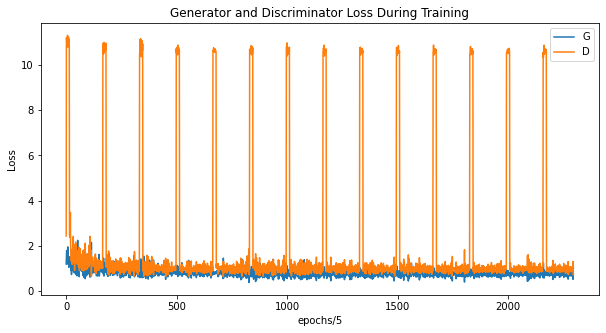

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("epochs/5")
plt.ylabel("Loss")
plt.legend()
plt.show()

Check how images progressed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


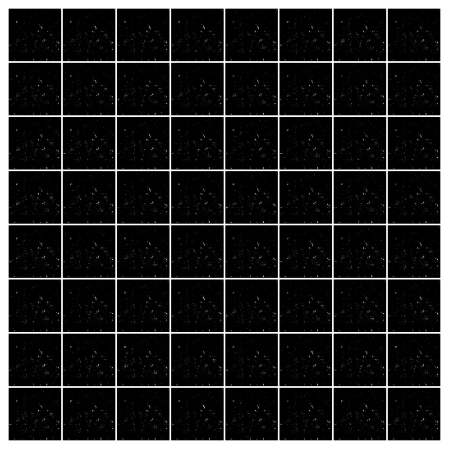

In [21]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1000)
ani.save("epochs.mp4", writer=writer)